In [20]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
import pydotplus
import joblib
from sklearn import metrics
from sklearn.metrics import f1_score, average_precision_score, cohen_kappa_score
from sklearn.metrics import precision_recall_curve

In [35]:
data = pd.read_csv('points.csv',index_col='FID')

# 数据预处理

In [37]:
road_dict = {0: 0, 300: 1, 500: 2, 800: 3, 1200: 4, 2000: 5, 200000: 6}
fault_dict = {0: 0, 300: 1, 500: 2, 800: 3, 1200: 4, 2000: 5, 3000:6, 50000: 7}
landuse_dict = {0: 0, 50: 1, 60: 2, 10: 3, 80: 4, 30: 5, 20: 6}
data['Distance from Road'] = [road_dict[item] for item in data['dis_road']]
data['Distance from Fault'] = [fault_dict[item] for item in data['dis_fault']]
data['Land Use'] = [landuse_dict[item] for item in data['Land_Use']]

In [38]:
name_dict = {
    'PlanCur': 'Plan Curvature',
    'Profile_cu': 'Profile Curvature',
    'Surface_Ro': 'Surface Roughness',
    'litho_rast': 'Lithology',
    'spi_sca2': 'SPI',
}

In [39]:
data.rename(columns=name_dict, inplace=True)

## 列名

In [40]:
float_label = [
    'Plan Curvature',
    'Profile Curvature',
    'SPI',
    'NDVI',
    #     'spi_1',
    'TWI',
    'TRI',
    'Surface Roughness',
    'Elevation',
    'Aspect',
    'Slope',
]
cate_label = [
    'Lithology', 'Distance from Road', 'Distance from Fault', 'Land Use'
]
labels = float_label + cate_label
predictors = labels
target_label = ['landslides']
all_label = labels + target_label

In [41]:
data[float_label] = np.round(data[float_label], 3)

C:\Users\312\.matplotlib


In [43]:
import matplotlib
print(matplotlib.get_configdir())
plt.rcParams.update({'font.size': 18})
matplotlib.rc('axes', titlesize=18)
plt.style.use(['science', 'notebook'])
plt.rcParams['font.serif'] = 'Times New Roman'

## 分割数据集

In [44]:
postive_num = len(data[data['landslides']==1])

In [45]:
gbr=data.groupby('landslides')
 
# 获取分组后gbr的数据
 
gbr.groups
 
# 分层抽样字典定义 组名：数据个数
 
typicalNDict={
        0:postive_num,
        1:postive_num,
        }
 
#函数定义
 
def typicalsamling(group,typicalNDict):
    name=group.name
    n=typicalNDict[name]
    return group.sample(n=n, random_state=10)
 
df=data.groupby(
        'landslides',group_keys=False
        ).apply(typicalsamling,typicalNDict)


In [46]:
df_train, df_test = train_test_split(df,test_size = 0.25, random_state=10,)
df_train_columns = df_train.columns

In [47]:
df_train.shape

(1071, 21)

In [48]:
print('数据不均衡比：', end='')
print(len(df[df['landslides'] == 0]) / len(df))
print('训练集不均衡比：',end='')
print(len(df_train[df_train['landslides']==0]) / len(df_train))
print('测试集不均衡比:', end='')
print(len(df_test[df_test['landslides']==0]) / len(df_test))

数据不均衡比：0.5
训练集不均衡比：0.49859943977591037
测试集不均衡比:0.5042016806722689


# XGBoost

In [16]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import  RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from itertools import combinations
from sklearn.model_selection import GridSearchCV

## 调参

In [149]:
def modelfit(alg,
             dtrain,
             predictors,
             useTrainCV=True,
             cv_folds=5,
             early_stopping_rounds=100):

    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values,
                              label=dtrain['landslides'].values)
        cvresult = xgb.cv(xgb_param,
                          xgtrain,
                          num_boost_round=alg.get_params()['n_estimators'],
                          nfold=cv_folds,
                          metrics='auc',
                          early_stopping_rounds=early_stopping_rounds,
                          verbose_eval=False)
        alg.set_params(n_estimators=cvresult.shape[0])

    # Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['landslides'], eval_metric='auc')

    # Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:, 1]
    
    print(cvresult.shape[0])
    # Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(
        dtrain['landslides'].values, dtrain_predictions))
    print("AUC Score (Train): %f" %
          metrics.roc_auc_score(dtrain['landslides'], dtrain_predprob))

    feat_imp = pd.Series(
        alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

### n_estimator

46

Model Report
Accuracy : 0.958
AUC Score (Train): 0.994410


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


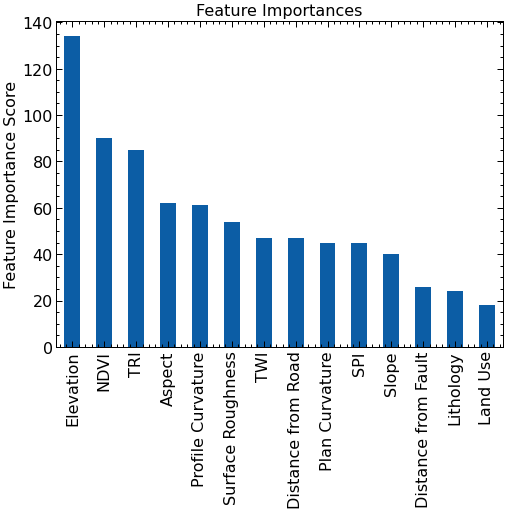

In [150]:
# Choose all predictors except target & IDcols
predictors = labels
xgb1 = xgb.sklearn.XGBClassifier(
    learning_rate=0.1,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27)
modelfit(xgb1, df_train, predictors)

### 调整max_depth和min_child_weight

In [151]:
param_test1 = {
    'max_depth': range(1, 100, 10),
    'min_child_weight': range(1, 100, 10)
}
gsearch1 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1,
                                                n_estimators=46,
                                                max_depth=5,
                                                min_child_weight=1,
                                                gamma=0,
                                                ubsample=0.8,
                                                colsample_bytree=0.8,
                                                objective='binary:logistic',
                                                nthread=4,
                                                scale_pos_weight=1,
                                                seed=27),
                        param_grid=param_test1,
                        scoring='f1',
                        n_jobs=4,
                        cv=5)
gsearch1.fit(df_train[predictors], df_train['landslides'])
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

[15:59:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "ubsample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:59:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


({'mean_fit_time': array([0.01399961, 0.01419997, 0.01320009, 0.01279984, 0.01239991,
         0.01160517, 0.01141205, 0.01219978, 0.01239996, 0.01139984,
         0.04759965, 0.02319241, 0.01960011, 0.01679997, 0.0138    ,
         0.0152    , 0.01360016, 0.01220007, 0.01200023, 0.01059995,
         0.04919982, 0.02479973, 0.01799984, 0.01420002, 0.01539984,
         0.01499982, 0.01419964, 0.01159992, 0.01319981, 0.01279998,
         0.05139961, 0.02379985, 0.01899981, 0.01699977, 0.01360006,
         0.01519985, 0.01420021, 0.0116003 , 0.01159973, 0.01120024,
         0.05219979, 0.02439985, 0.01899996, 0.0170001 , 0.01539955,
         0.01259971, 0.01220016, 0.01079988, 0.01260009, 0.01160021,
         0.04859982, 0.023     , 0.0196002 , 0.01819983, 0.01520033,
         0.01379967, 0.01399951, 0.01239996, 0.01220002, 0.0119998 ,
         0.04860001, 0.02559986, 0.01819992, 0.0157999 , 0.0157999 ,
         0.01300006, 0.01339979, 0.01159992, 0.01199989, 0.01179953,
         0.048199

In [161]:
param_test2 = {
    'max_depth': range(1,20),
    'min_child_weight': range(1,20),
}
gsearch2 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1,
                                                n_estimators=46,
                                                max_depth=11,
                                                min_child_weight=11,
                                                subsample=0.8,
                                                colsample_bytree=0.8,
                                                objective='binary:logistic',
                                                nthread=4,
                                                scale_pos_weight=1,
                                                seed=27),
                        param_grid=param_test2,
                        scoring='f1',
                        n_jobs=6,
                        cv=5)
gsearch2.fit(df_train[predictors], df_train['landslides'])
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

[16:04:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


({'mean_fit_time': array([0.01819921, 0.01759977, 0.01480002, 0.01419997, 0.01480007,
         0.01439996, 0.0138    , 0.01519995, 0.01439991, 0.01400008,
         0.0151998 , 0.01420002, 0.01459999, 0.01420021, 0.01420002,
         0.01419997, 0.01339979, 0.01319995, 0.0131999 , 0.01819992,
         0.01859975, 0.01779995, 0.01720004, 0.01779995, 0.01739993,
         0.01740007, 0.0171999 , 0.01699996, 0.01680002, 0.01779971,
         0.01679997, 0.01719999, 0.01639991, 0.01699986, 0.01660008,
         0.01579981, 0.01739988, 0.01600013, 0.023     , 0.02219992,
         0.0210001 , 0.02139993, 0.02019987, 0.01979995, 0.01980004,
         0.0203999 , 0.01980019, 0.01960011, 0.01940007, 0.01899986,
         0.01819992, 0.01840005, 0.01859994, 0.01879992, 0.01799989,
         0.01839986, 0.01780009, 0.0269999 , 0.02519999, 0.02500005,
         0.02399983, 0.02420001, 0.02340016, 0.02219996, 0.02140002,
         0.02219996, 0.02199998, 0.02139993, 0.02100015, 0.02039995,
         0.019799

### 调整gamma

In [162]:
param_test3 = {
    'gamma': [i/100 for i in range(0,100)]
}
gsearch3 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1,
                                                n_estimators=46,
                                                max_depth=2,
                                                min_child_weight=8,
                                                gamma=0,
                                                subsample=0.8,
                                                colsample_bytree=0.8,
                                                objective='binary:logistic',
                                                nthread=4,
                                                scale_pos_weight=1,
                                                seed=27),
                        param_grid=param_test3,
                        scoring='f1',
                        n_jobs=4,
                        cv=5)
gsearch3.fit(df_train[predictors], df_train['landslides'])
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

[16:05:08] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


({'mean_fit_time': array([0.01799936, 0.01720009, 0.01659989, 0.0164    , 0.01719961,
         0.0171999 , 0.01719999, 0.01759992, 0.01819987, 0.01579981,
         0.01679993, 0.01699986, 0.01839976, 0.01700001, 0.01759992,
         0.01899981, 0.01620002, 0.01800008, 0.01619992, 0.01900005,
         0.01620002, 0.01920004, 0.01919985, 0.01759992, 0.01760011,
         0.0190001 , 0.01740003, 0.01660004, 0.01819992, 0.01520004,
         0.01679983, 0.01619978, 0.01839995, 0.01559973, 0.01779995,
         0.01739998, 0.0178    , 0.01620002, 0.01739988, 0.01619983,
         0.01700001, 0.01799998, 0.01599984, 0.01639991, 0.01879992,
         0.01679997, 0.01840005, 0.01699986, 0.01760001, 0.01719999,
         0.01820006, 0.0177999 , 0.01660004, 0.01700001, 0.01639991,
         0.01679997, 0.0178    , 0.01799998, 0.01740007, 0.01599989,
         0.01600003, 0.01679997, 0.01699986, 0.01740003, 0.01819997,
         0.01699996, 0.01739993, 0.01759996, 0.01499996, 0.01880002,
         0.019200

145

Model Report
Accuracy : 0.9225
AUC Score (Train): 0.978159


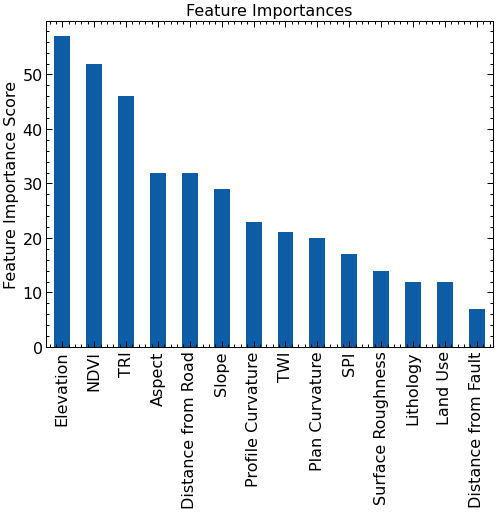

In [163]:
xgb2 = XGBClassifier(learning_rate=0.1,
                     n_estimators=1000,
                     max_depth=2,
                     min_child_weight=8,
                     gamma=0.42,
                     subsample=0.8,
                     colsample_bytree=0.8,
                     objective='binary:logistic',
                     nthread=4,
                     scale_pos_weight=1,
                     seed=27)
modelfit(xgb2, df_train, predictors)

### 调整子样本和colsample_bytree

In [164]:
param_test4 = {
    'subsample': [i/10 for i in range(1,10)],
    'colsample_bytree': [i /10 for i in range(1,10)]
} 
gsearch4 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1,
                                                n_estimators=145,
                                                max_depth=2,
                                                min_child_weight=8,
                                                gamma=0.42,
                                                subsample=0.8,
                                                colsample_bytree=0.8,
                                                objective='binary:logistic',
                                                nthread=4,
                                                scale_pos_weight=1,
                                                seed=27),
                        param_grid=param_test4,
                        scoring='f1',
                        n_jobs=4,
                        cv=5)
gsearch4.fit(df_train[predictors], df_train['landslides'])
gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_

[16:05:55] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


({'mean_fit_time': array([0.0340055 , 0.03099995, 0.03259993, 0.03179994, 0.03459983,
         0.03220487, 0.0364049 , 0.03559971, 0.03539982, 0.02700005,
         0.0302    , 0.03540015, 0.0336    , 0.03739996, 0.03519993,
         0.0336    , 0.03779974, 0.03599997, 0.02679982, 0.02919993,
         0.03439989, 0.0335999 , 0.03600001, 0.0408    , 0.03260016,
         0.03739982, 0.03679981, 0.02859988, 0.03159995, 0.03700008,
         0.03459983, 0.03839993, 0.03699989, 0.03759995, 0.03599987,
         0.03639994, 0.02519999, 0.03179989, 0.0329998 , 0.03659987,
         0.03399997, 0.03640003, 0.0388001 , 0.03979983, 0.03680019,
         0.02739978, 0.0323998 , 0.0349997 , 0.03899984, 0.03739972,
         0.03860002, 0.03959975, 0.03839993, 0.03939981, 0.0289999 ,
         0.03059998, 0.0335999 , 0.03720012, 0.04080009, 0.04039989,
         0.03759995, 0.04039984, 0.04179983, 0.02699981, 0.03259959,
         0.0355999 , 0.03779964, 0.04119935, 0.04219985, 0.04179988,
         0.041799

In [24]:
param_test5 = {
    'subsample': [i/100 for i in range(80,100)],
    'colsample_bytree': [i /100 for i in range(70,90)]
} 
gsearch5 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1,
                                                n_estimators=33,
                                                max_depth=4,
                                                min_child_weight=5,
                                                gamma=0.5,
                                                subsample=0.8,
                                                colsample_bytree=0.7,
                                                objective='binary:logistic',
                                                nthread=4,
                                                scale_pos_weight=1,
                                                seed=27),
                        param_grid=param_test5,
                        scoring='roc_auc',
                        n_jobs=4,
                        cv=5)
gsearch5.fit(df_train[predictors], df_train['landslides'])
gsearch5.cv_results_, gsearch5.best_params_, gsearch5.best_score_

[10:30:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\312\.conda\envs\lbtf2\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


({'mean_fit_time': array([0.02360005, 0.01699953, 0.0184001 , 0.01740022, 0.0168004 ,
         0.01819992, 0.01799974, 0.0178    , 0.0191999 , 0.01699986,
         0.01879973, 0.01859999, 0.01700015, 0.01839962, 0.01759977,
         0.01719975, 0.01880012, 0.01900015, 0.01799984, 0.01939945,
         0.01899977, 0.01899962, 0.01760006, 0.01900034, 0.01680026,
         0.01839952, 0.0171998 , 0.01759958, 0.01800013, 0.01820011,
         0.01879988, 0.01839981, 0.01760006, 0.01779995, 0.0178    ,
         0.01940007, 0.01959977, 0.01960001, 0.01620016, 0.01639953,
         0.01940007, 0.01820011, 0.01920004, 0.01779985, 0.01719985,
         0.01800013, 0.01920004, 0.02059984, 0.01899996, 0.01799974,
         0.01939993, 0.01699982, 0.01899972, 0.02059994, 0.01900034,
         0.01859961, 0.01819978, 0.01799989, 0.01860013, 0.01699977,
         0.01979961, 0.01940002, 0.01660013, 0.01720009, 0.01699996,
         0.01820021, 0.0185998 , 0.01819978, 0.02039967, 0.01879964,
         0.018999

### 调整正则化参数

In [165]:
param_test6 = {
    'reg_alpha':[1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100]
} 
gsearch6 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1,
                                                n_estimators=145,
                                                max_depth=2,
                                                min_child_weight=8,
                                                gamma=0.42,
                                                subsample=0.82,
                                                colsample_bytree=0.7,
                                                objective='binary:logistic',
                                                nthread=4,
                                                scale_pos_weight=1,
                                                seed=27),
                        param_grid=param_test6,
                        scoring='f1',
                        n_jobs=4,
                        cv=5)
gsearch6.fit(df_train[predictors], df_train['landslides'])
gsearch6.cv_results_, gsearch6.best_params_, gsearch6.best_score_

[16:06:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


({'mean_fit_time': array([0.04979472, 0.04298773, 0.04119983, 0.04039993, 0.03899994,
         0.04039984, 0.04019957, 0.03780522]),
  'std_fit_time': array([0.00700738, 0.0040436 , 0.00353779, 0.00422396, 0.00414728,
         0.00241641, 0.00231485, 0.00075744]),
  'mean_score_time': array([0.00279994, 0.00239968, 0.00219989, 0.00199995, 0.00220003,
         0.0024003 , 0.00260015, 0.00259466]),
  'std_score_time': array([0.00040004, 0.00080007, 0.00098045, 0.00063241, 0.00039999,
         0.00049006, 0.00048994, 0.00049654]),
  'param_reg_alpha': masked_array(data=[1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
               mask=[False, False, False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'reg_alpha': 1e-05},
   {'reg_alpha': 0.0001},
   {'reg_alpha': 0.001},
   {'reg_alpha': 0.01},
   {'reg_alpha': 0.1},
   {'reg_alpha': 1},
   {'reg_alpha': 10},
   {'reg_alpha': 100}],
  'split0_test_score': array([0.90497738, 0.9049

In [33]:
param_test7 = {
    'reg_alpha':[i/100 for i in range(1,30)]
} 
gsearch7 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1,
                                                n_estimators=131,
                                                max_depth=3,
                                                min_child_weight=1,
                                                gamma=0.5,
                                                subsample=0.8,
                                                colsample_bytree=0.72,
                                                objective='binary:logistic',
                                                nthread=6,
                                                scale_pos_weight=1,
                                                reg_alpha = 0.09,
                                                seed=27),
                        param_grid=param_test7,
                        scoring='roc_auc',
                        n_jobs=4,
                        cv=5)
gsearch7.fit(df_train[predictors], df_train['landslides'])
gsearch7.cv_results_, gsearch7.best_params_, gsearch7.best_score_

[21:59:07] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\312\.conda\envs\lbtf2\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


({'mean_fit_time': array([0.05719924, 0.04819984, 0.04720006, 0.04700007, 0.04820008,
         0.04639983, 0.04680014, 0.04620023, 0.04779983, 0.04580007,
         0.04700007, 0.04780002, 0.04780564, 0.04660015, 0.0461998 ,
         0.04639997, 0.04659996, 0.04680004, 0.04639997, 0.04680009,
         0.04939995, 0.04699998, 0.04739995, 0.04720011, 0.04659977,
         0.04720016, 0.04779992, 0.04700003, 0.0486001 ]),
  'std_fit_time': array([0.00601319, 0.00231525, 0.00097989, 0.00200002, 0.00305944,
         0.00048988, 0.00146968, 0.00203962, 0.00116622, 0.00116628,
         0.00109545, 0.002227  , 0.00270898, 0.00162482, 0.00132662,
         0.00101987, 0.00101982, 0.00116604, 0.00119987, 0.00040004,
         0.00174355, 0.00089452, 0.00233253, 0.0011662 , 0.00135656,
         0.00248175, 0.00183285, 0.00109558, 0.00174339]),
  'mean_score_time': array([0.00260005, 0.00240006, 0.00220013, 0.00220013, 0.00240026,
         0.00239992, 0.00219989, 0.00219979, 0.00220003, 0.00219998,
  

56

Model Report
Accuracy : 0.9113
AUC Score (Train): 0.965671


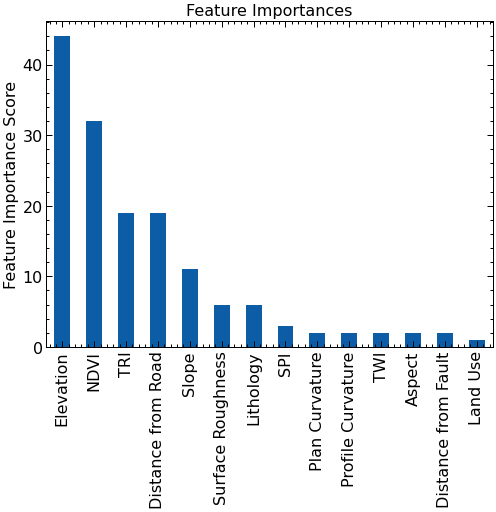

In [166]:
xgb3 = XGBClassifier(learning_rate=0.1,
                     n_estimators=1000,
                     max_depth=2,
                     min_child_weight=8,
                     gamma=0.4,
                     subsample=0.8,
                     colsample_bytree=0.7,
                     objective='binary:logistic',
                     nthread=6,
                     scale_pos_weight=1,
                     reg_alpha=0.01,
                     seed=27)
modelfit(xgb3, df_train, predictors)

## 最终参数

335

Model Report
Accuracy : 0.9057
AUC Score (Train): 0.961623


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


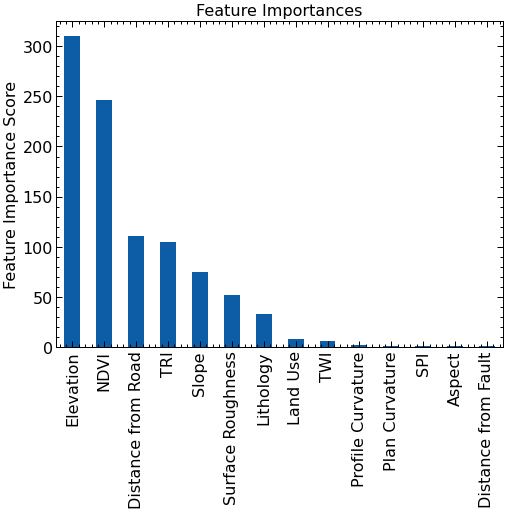

In [167]:
predictors = labels
xgb4 = XGBClassifier(learning_rate=0.01,
                     n_estimators=5000,
                     max_depth=2,
                     min_child_weight=8,
                     gamma=0.4,
                     subsample=0.8,
                     colsample_bytree=0.7,
                     objective='binary:logistic',
                     nthread=6,
                     scale_pos_weight=1,
                     reg_alpha=0.01,
                     seed=27)
modelfit(xgb4, df_train, predictors)

In [168]:
xgb4 = XGBClassifier(learning_rate=0.01,
                     n_estimators=335,
                     max_depth=2,
                     min_child_weight=8,
                     gamma=0.4,
                     subsample=0.8,
                     colsample_bytree=0.7,
                     objective='binary:logistic',
                     nthread=6,
                     scale_pos_weight=1,
                     reg_alpha=0.01,
                     seed=27)
xgb4.fit(df_train[predictors], df_train['landslides'])

[16:08:38] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7,
              enable_categorical=False, gamma=0.4, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=2,
              min_child_weight=8, missing=nan, monotone_constraints='()',
              n_estimators=335, n_jobs=6, nthread=6, num_parallel_tree=1,
              predictor='auto', random_state=27, reg_alpha=0.01, reg_lambda=1,
              scale_pos_weight=1, seed=27, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=None)

## 测试集

### 保存模型

In [254]:
joblib.dump(xgb4, r'xgb_model.pkl')

['xgb_model.pkl']

### 加载模型

In [16]:
xgb4 = joblib.load(r'xgb_model.pkl')

### 测试

In [49]:
xgb_pred_train = xgb4.predict(df_train[predictors])
xgb_prob_train = xgb4.predict_proba(df_train[predictors])[:, 1]
f1_train = f1_score(df_train['landslides'], xgb_pred_train)
print('train_f1:{}'.format(f1_train))

xgb_pred_test = xgb4.predict(df_test[predictors])  # 预测
xgb_prob_test = xgb4.predict_proba(df_test[predictors])[:, 1]

auc_value = roc_auc_score(df_test['landslides'], xgb_prob_test)

fpr, tpr, thresholds_roc = roc_curve(df_test['landslides'], xgb_prob_test)
print('auc:{}'.format(auc_value))

xgb_recall_value = recall_score(df_test['landslides'], xgb_pred_test)

print('训练集预测均值：{}'.format(1-xgb_prob_train.mean()))
print('训练集标签均值：{}'.format(1-xgb_pred_train.mean()))
print('测试集预测均值：{}'.format(1-xgb_prob_test.mean()))
print('测试集标签均值：{}'.format(1-xgb_pred_test.mean()))

print('racall:{}'.format(xgb_recall_value))
xgb_precision_value = precision_score(df_test['landslides'], xgb_pred_test)
print('precision:{}'.format(xgb_precision_value))
xgb_f1 = f1_score(df_test['landslides'], xgb_pred_test)
print('f1:{}'.format(xgb_f1))
precision_list, recall_list, thresholds = precision_recall_curve(
    df_test['landslides'], xgb_prob_test)

auc_pr = average_precision_score(df_test['landslides'], xgb_prob_test)
print('prc:{}'.format(auc_pr))
print(xgb_pred_test.mean())
print(xgb_prob_test.mean())

train_f1:0.9087624209575428
auc:0.9193816698053987
训练集预测均值：0.49764102697372437
训练集标签均值：0.4677871148459384
测试集预测均值：0.5025475323200226
测试集标签均值：0.4649859943977591
racall:0.9152542372881356
precision:0.8481675392670157
f1:0.8804347826086956
prc:0.8903313209272468
0.5350140056022409
0.49745247


In [50]:
xgb_precisions, xgb_recalls, xgb_fpr, xgb_tpr, xgb_prc, xgb_auc = precision_list, recall_list, fpr, tpr, auc_pr, auc_value

## 特征解释

In [171]:
import shap

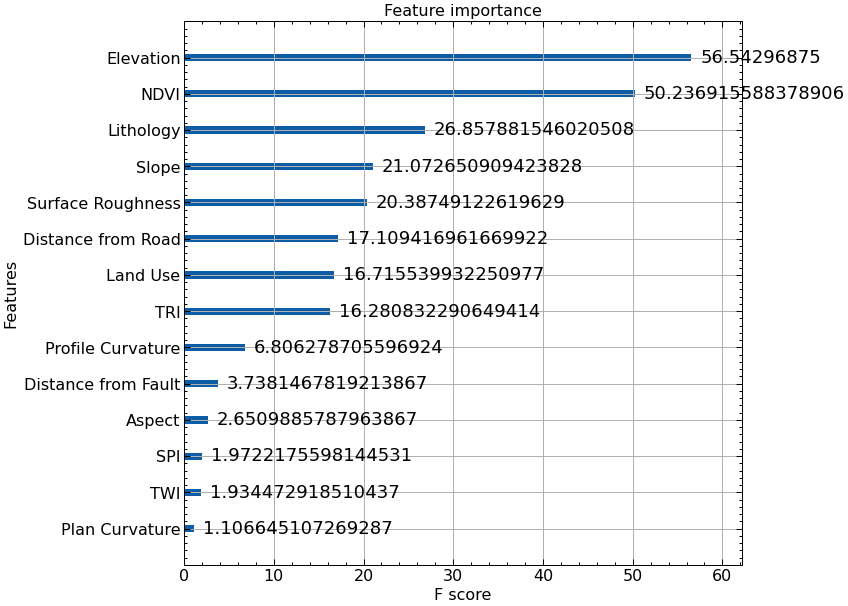

In [172]:
ax = xgb.plot_importance(xgb4, importance_type='gain')
fig = ax.figure
fig.set_size_inches(10, 10)

In [173]:
explainer = shap.TreeExplainer(xgb4,
                               model_output='probability',
                               feature_perturbation='interventional',
                               data=df_test[predictors])  # 初始化解释器
shap.initjs()  #初始化JS
shap_values = explainer.shap_values(df_test[predictors])  #计算每个样本的每个特征的SHAP值

In [174]:
y_base = explainer.expected_value
print(y_base)

print(xgb_prob_test.mean())

0.4183709501544039
0.49745247


### 个体解释

In [175]:
fig_root = os.getcwd()
fig_type = 'landslide_sample'
for i in tqdm(np.where(df_test['landslides']==1)[0]):
    shap.force_plot(explainer.expected_value,
                    shap_values[i, :],
                    df_test[predictors].iloc[i],
                    matplotlib=True,
                    show=False,
                    # link='logit',
                   )
    figure_name = str(i)+'_'+'{:.2f}'.format(xgb_prob_test[i])
    figpath = os.path.join(fig_root,'figure', 'xgb', fig_type, figure_name + '.PNG')
    plt.savefig(figpath, dpi=600)
    plt.close()

100%|████████████████████████████████████████████████████████████████████████████████| 177/177 [04:49<00:00,  1.64s/it]


In [176]:
fig_root = os.getcwd()
fig_type = 'no_landslide'
for i in tqdm(np.where(df_test['landslides']==0)[0]):
    shap.force_plot(explainer.expected_value,
                    shap_values[i, :],
                    df_test[predictors].iloc[i],
                    matplotlib=True,
                    show=False,
                    # link='logit',
                   )
    figure_name = str(i)+'_'+'{:.2f}'.format(xgb_prob_test[i])
    figpath = os.path.join(fig_root,'figure', 'xgb', fig_type, figure_name + '.PNG')
    plt.savefig(figpath, dpi=600)
    plt.close() 

100%|████████████████████████████████████████████████████████████████████████████████| 180/180 [04:57<00:00,  1.65s/it]


### summary

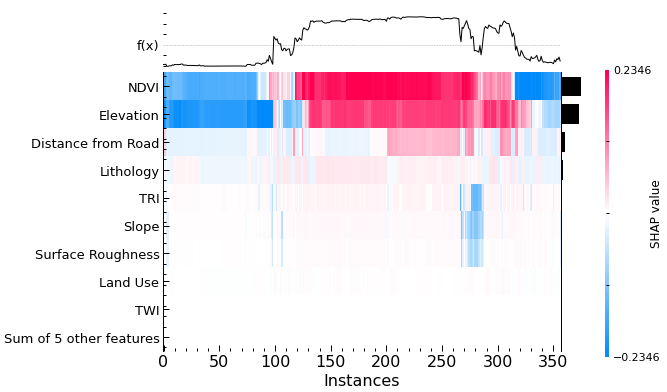

In [177]:
shap_values_obj = explainer(df_test[labels])
fig_root = os.getcwd()
fig_type = 'summary'
shap.plots.heatmap(shap_values_obj,show=False)
figpath = os.path.join(fig_root,'figure', fig_type, 'xgb_heat.png')
plt.savefig(figpath, dpi=600)

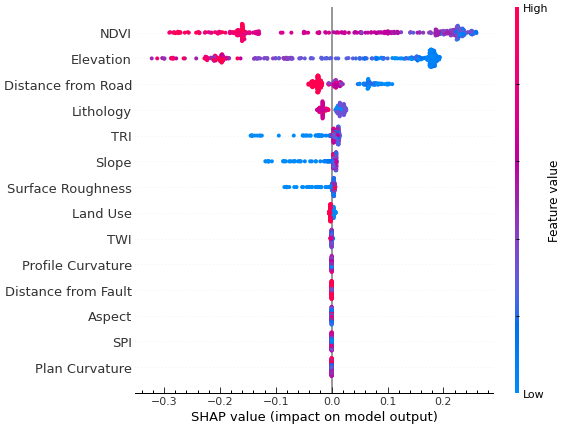

In [178]:
fig_root = os.getcwd()
fig_type = 'summary'
shap.summary_plot(shap_values, df_test[predictors],show=False)
figpath = os.path.join(fig_root,'figure', fig_type, 'xgb_summary.png')
plt.savefig(figpath, dpi=600)

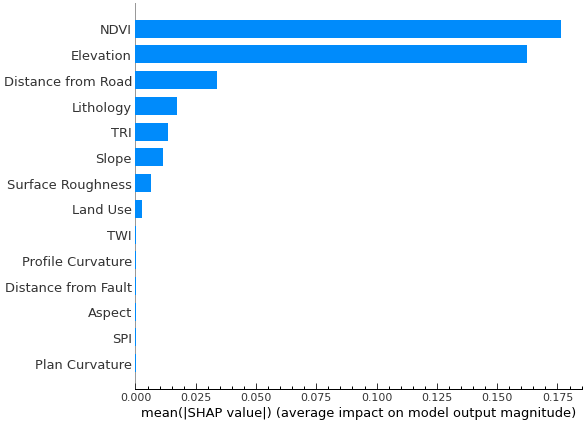

In [179]:
fig_root = os.getcwd()
fig_type = 'summary'
shap.summary_plot(shap_values, df_test[predictors],plot_type="bar",show=False)
figpath = os.path.join(fig_root,'figure', fig_type, 'xgb_bar.png')
plt.savefig(figpath, dpi=600)

In [180]:
shap_interaction_values = shap.TreeExplainer(xgb4).shap_interaction_values(df_test[labels])

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


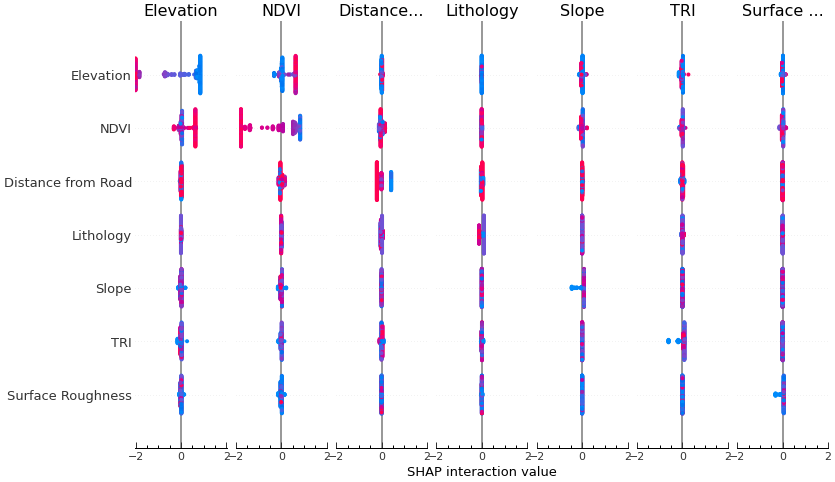

In [181]:
fig_root = os.getcwd()
fig_type = 'summary'
shap.summary_plot(shap_interaction_values, df_test[predictors],show=False)
figpath = os.path.join(fig_root,'figure', fig_type, 'xgb_all.png')
plt.savefig(figpath, dpi=600)

### dependence_plot

In [182]:
fig_root = os.path.join(os.getcwd(),'figure', 'xgb')
fig_type = 'dependence'
for item in tqdm(predictors):
    shap.dependence_plot(item,
                         shap_values,
                         df_test[predictors],
                         interaction_index=None,
                         show=False)
    figpath = os.path.join(fig_root, fig_type, item + '.PNG')
    plt.savefig(figpath, dpi=600)
    plt.close()

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  3.18it/s]


### Interaction

In [183]:
fig_root = os.path.join(os.getcwd(),'figure', 'xgb')
fig_type = 'Interaction'
for i in tqdm(range(len(predictors))):
    for j in range(len(predictors)):
        # print(X_columns[i] + "_" + X_columns[j])
        col_i = predictors[i]
        col_j = predictors[j]
        shap.dependence_plot(col_i,
                             shap_values,
                             df_test[predictors],
#                              interaction_index=col_j,
                             show=False)
        filename = col_i + '_' + col_j
        figpath = os.path.join(fig_root, fig_type, filename + '.PNG')
        plt.savefig(figpath, dpi=600)
        plt.close()

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:19<00:00,  5.69s/it]


### Interaction_value

In [184]:
fig_root = os.path.join(os.getcwd(),'figure', 'xgb')
fig_type = 'Interaction_value'
for i in tqdm(range(len(predictors))):
    for j in range(len(predictors)):
        # print(X_columns[i] + "_" + X_columns[j])
        col_i = predictors[i]
        col_j = predictors[j]
#         print(col_i, col_j)
        shap.dependence_plot((col_i, col_j),
                             shap_interaction_values,
                             df_test[predictors],
                             interaction_index=col_j,
                             show=False)
        filename = col_i + '_' + col_j
        figpath = os.path.join(fig_root, fig_type, filename + '.PNG')
        plt.savefig(figpath, dpi=600)
        plt.close()

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:17<00:00,  5.51s/it]


# LightGBM

In [65]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import  RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score, average_precision_score, cohen_kappa_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from itertools import combinations
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

In [66]:
labels

['Plan Curvature',
 'Profile Curvature',
 'SPI',
 'NDVI',
 'TWI',
 'TRI',
 'Surface Roughness',
 'Elevation',
 'Aspect',
 'Slope',
 'Lithology',
 'Distance from Road',
 'Distance from Fault',
 'Land Use']

In [67]:
lgb_train = lgb.Dataset(df_train[labels],
                        label=df_train['landslides'],
                        categorical_feature=cate_label,
                        free_raw_data=False)
lgb_test = lgb.Dataset(df_test[labels],
                       label=df_test['landslides'],
                       categorical_feature=cate_label,
                       free_raw_data=False)

## 调参

In [68]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',  # 用于分类
    'learning_rate': 0.1,  # 选定一较高的值，通常是0.1
    'num_leaves': 50,  # 由于lightGBM是leaves_wise生长，官方说法是要小于2^max_depth
    'max_depth': 6,  # 由于数据集不大，所以选择一个适中的值，4-10都可以
    'subsample': 0.8,  # 数据采样
    'colsample_bytree': 0.8,  # 特征采样
}

cv_results = lgb.cv(
    params,
    lgb_train,
    num_boost_round=1000,
    nfold=5,
    stratified=False,
    shuffle=True,
    metrics='auc',
    early_stopping_rounds=50,
    seed=0,
)

print('best n_estimators:', len(cv_results['auc-mean']))
print('best cv score:', pd.Series(cv_results['auc-mean']).max())

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 435, number of negative: 421
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2565
[LightGBM] [Info] Number of data points in the train set: 856, number of used features: 14
[LightGBM] [Info] Number of positive: 430, number of negative: 426
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2565
[LightGBM] [Info] Number of data points in the train set: 856, number of used features: 14
[LightGBM] [Info] Number of positive: 434, number of negative: 422
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000120 seconds.
You can set `force_col_wise=true

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


In [71]:
best_params = {'learning_rate':0.1,
#               'bagging_fraction':0.8,
#               'feature_fraction':0.8,
              'boosting_type': 'gbdt',
              'metrics':'auc',
              'objective':'binary',
              'n_estimators':39}

### max_depth和num_leaves

In [72]:
params_test1 = {'max_depth': range(1, 8, 1), 'num_leaves': range(5, 100, 5)}

gsearch1 = GridSearchCV(estimator=lgb.LGBMClassifier(**best_params),
                        param_grid=params_test1,
                        scoring='f1',
                        cv=5,
                        n_jobs=-1)
gsearch1.fit(df_train[labels], df_train['landslides'])
gsearch1.best_score_, gsearch1.best_params_

(0.9015556981099071, {'max_depth': 3, 'num_leaves': 10})

In [73]:
best_params.update(gsearch1.best_params_)

In [74]:
params_test2 = {'max_depth': range(2, 6, 1), 'num_leaves': range(5, 15, 1)}

gsearch2 = GridSearchCV(estimator=lgb.LGBMClassifier(**best_params),
                        param_grid=params_test1,
                        scoring='f1',
                        cv=5,
                        n_jobs=-1)
gsearch2.fit(df_train[labels], df_train['landslides'])
gsearch2.best_score_, gsearch2.best_params_

(0.9015556981099071, {'max_depth': 3, 'num_leaves': 10})

In [75]:
best_params.update(gsearch2.best_params_)

### min_data_in_leaf

In [76]:
params_test3 = {
    'min_data_in_leaf': range(1, 102, 10)
}

gsearch3 = GridSearchCV(estimator=lgb.LGBMClassifier(**best_params),
                        param_grid=params_test3,
                        scoring='f1',
                        cv=5,
                        n_jobs=-1)
gsearch3.fit(df_train[labels], df_train['landslides'])
gsearch3.best_score_, gsearch3.best_params_

(0.9045621814684186, {'min_data_in_leaf': 11})

In [77]:
best_params.update(gsearch3.best_params_)

In [78]:
params_test4 = {
    'min_data_in_leaf': range(1, 20, 1)
}

gsearch4 = GridSearchCV(estimator=lgb.LGBMClassifier(**best_params),
                        param_grid=params_test4,
                        scoring='f1',
                        cv=5,
                        n_jobs=-1)
gsearch4.fit(df_train[labels], df_train['landslides'])
gsearch4.best_score_, gsearch4.best_params_

(0.9045621814684186, {'min_data_in_leaf': 11})

In [79]:
best_params.update(gsearch4.best_params_)

### feature_fraction、bagging_fraction、bagging_freq

In [80]:
params_test5 = {
    'feature_fraction': [0.6, 0.7, 0.8, 0.9, 1.0],
    'bagging_fraction': [0.6, 0.7, 0.8, 0.9, 1.0],
    'bagging_freq': range(0, 81, 10)
}

gsearch5 = GridSearchCV(estimator=lgb.LGBMClassifier(**best_params),
                        param_grid=params_test5,
                        scoring='f1',
                        cv=5,
                        n_jobs=-1)
gsearch5.fit(df_train[labels], df_train['landslides'])
gsearch5.best_score_, gsearch5.best_params_

(0.9045621814684186,
 {'bagging_fraction': 0.6, 'bagging_freq': 0, 'feature_fraction': 1.0})

In [81]:
best_params.update(gsearch5.best_params_)

### L1和L2

In [82]:
params_test6 = {
    'lambda_l1': [1e-5, 1e-3, 1e-1, 0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
    'lambda_l2': [1e-5, 1e-3, 1e-1, 0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
}
gsearch6= GridSearchCV(estimator=lgb.LGBMClassifier(**best_params),
                        param_grid=params_test6,
                        scoring='f1',
                        cv=5,
                        n_jobs=-1)
gsearch6.fit(df_train[labels], df_train['landslides'])
gsearch6.best_score_, gsearch6.best_params_

(0.9045621814684186, {'lambda_l1': 1e-05, 'lambda_l2': 1e-05})

In [83]:
best_params.update(gsearch6.best_params_)

## 最终参数

In [84]:
best_params.update({'learning_rate':0.01})

In [85]:
cv_results = lgb.cv(
    best_params,
    lgb_train,
    num_boost_round=1000,
    nfold=5,
    stratified=False,
    shuffle=True,
    metrics='auc',
    early_stopping_rounds=50,
    seed=0,
)

print('best n_estimators:', len(cv_results['auc-mean']))
print('best cv score:', pd.Series(cv_results['auc-mean']).max())

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=0.8 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=0.8 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Info] Number of positive: 435, number of negative: 421
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2565
[LightGBM] [Info] Number of data points in the train set: 856, number of used features: 14
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.8 will be ig

Found `n_estimators` in params. Will use it instead of argument
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.
categorical_column in param dict is overridden.


In [86]:
best_params.update({'n_estimators':39})

In [87]:
lgb_model = lgb.LGBMClassifier(**best_params)
lgb_model.fit(df_train[labels], df_train['landslides'])

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] lambda_l1 is set=1e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1e-05
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=1e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1e-05
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


LGBMClassifier(bagging_fraction=0.6, bagging_freq=0, feature_fraction=1.0,
               lambda_l1=1e-05, lambda_l2=1e-05, learning_rate=0.01,
               max_depth=3, metrics='auc', min_data_in_leaf=11, n_estimators=39,
               num_leaves=10, objective='binary')

## 测试

### 保存模型

In [251]:
joblib.dump(lgb_model, r'lgb_model.pkl')

['lgb_model.pkl']

### 加载模型

In [23]:
lgb_model = joblib.load(r'lgb_model.pkl')

### 测试

In [51]:
lgb_pred_train = lgb_model.predict(df_train[labels])
lgb_prob_train = lgb_model.predict_proba(df_train[labels])[:, 1]
f1_train = f1_score(df_train['landslides'], lgb_pred_train)
print('train_f1:{}'.format(f1_train))

lgb_pred_test = lgb_model.predict(df_test[labels])  # 预测
lgb_prob_test = lgb_model.predict_proba(df_test[labels])[:, 1]

auc_value = roc_auc_score(df_test['landslides'], lgb_prob_test)

fpr, tpr, thresholds_roc = roc_curve(df_test['landslides'], lgb_prob_test)
print('auc:{}'.format(auc_value))

lgb_recall_value = recall_score(df_test['landslides'], lgb_pred_test)

print('训练集预测均值：{}'.format(1-lgb_prob_train.mean()))
print('训练集标签均值：{}'.format(1-lgb_pred_train.mean()))
print('测试集预测均值：{}'.format(1-lgb_prob_test.mean()))
print('测试集标签均值：{}'.format(1-lgb_pred_test.mean()))

print('racall:{}'.format(lgb_recall_value))
lgb_precision_value = precision_score(df_test['landslides'], lgb_pred_test)
print('precision:{}'.format(lgb_precision_value))
lgb_f1 = f1_score(df_test['landslides'], lgb_pred_test)
print('f1:{}'.format(lgb_f1))
precision_list, recall_list, thresholds = precision_recall_curve(
    df_test['landslides'], lgb_prob_test)

auc_pr = average_precision_score(df_test['landslides'], lgb_prob_test)
print('prc:{}'.format(auc_pr))
print(lgb_pred_test.mean())
print(lgb_prob_test.mean())

train_f1:0.9009990917347867
auc:0.8994036409290647
训练集预测均值：0.49858074272346964
训练集标签均值：0.4733893557422969
测试集预测均值：0.500687282445242
测试集标签均值：0.4817927170868347
racall:0.8926553672316384
precision:0.8540540540540541
f1:0.87292817679558
prc:0.8460054032552486
0.5182072829131653
0.49931271755475803


In [52]:
lgb_precisions, lgb_recalls, lgb_fpr, lgb_tpr, lgb_prc, lgb_auc = precision_list, recall_list, fpr, tpr, auc_pr, auc_value

## 特征解释

In [90]:
predictors = labels

In [91]:
import shap

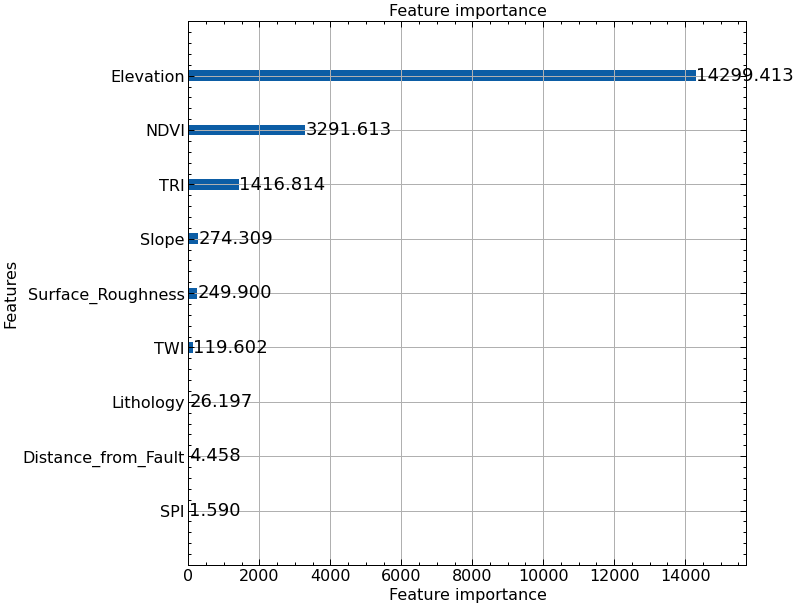

In [92]:
ax = lgb.plot_importance(lgb_model, importance_type='gain')
fig = ax.figure
fig.set_size_inches(10, 10)

In [93]:
explainer = shap.TreeExplainer(lgb_model,
                               model_output='probability',
                               feature_perturbation='interventional',
                               data=df_test[predictors])  # 初始化解释器
shap.initjs()  #初始化JS
shap_values = explainer.shap_values(df_test[predictors])  #计算每个样本的每个特征的SHAP值

In [94]:
y_base = explainer.expected_value
print(y_base)

print(lgb_prob_test.mean())

0.4728857138645899
0.49931271755475803


In [95]:
model_name = 'lgb'

### 个体解释

In [96]:
fig_root = os.getcwd()
fig_type = 'landslide_sample'
for i in tqdm(np.where(df_test['landslides']==1)[0]):
    shap.force_plot(explainer.expected_value,
                    shap_values[i, :],
                    df_test[predictors].iloc[i],
                    matplotlib=True,
                    show=False,
                    # link='logit',
                   )
    figure_name = str(i)+'_'+'{:.2f}'.format(lgb_prob_test[i])
    figpath = os.path.join(fig_root,'figure', model_name, fig_type, figure_name + '.PNG')
    plt.savefig(figpath, dpi=600)
    plt.close()

100%|████████████████████████████████████████████████████████████████████████████████| 177/177 [04:39<00:00,  1.58s/it]


In [97]:
fig_root = os.getcwd()
fig_type = 'no_landslide'
for i in tqdm(np.where(df_test['landslides']==0)[0]):
    shap.force_plot(explainer.expected_value,
                    shap_values[i, :],
                    df_test[predictors].iloc[i],
                    matplotlib=True,
                    show=False,
                    # link='logit',
                   )
    figure_name = str(i)+'_'+'{:.2f}'.format(lgb_prob_test[i])
    figpath = os.path.join(fig_root,'figure', model_name, fig_type, figure_name + '.PNG')
    plt.savefig(figpath, dpi=600)
    plt.close() 

100%|████████████████████████████████████████████████████████████████████████████████| 180/180 [04:44<00:00,  1.58s/it]


### summary

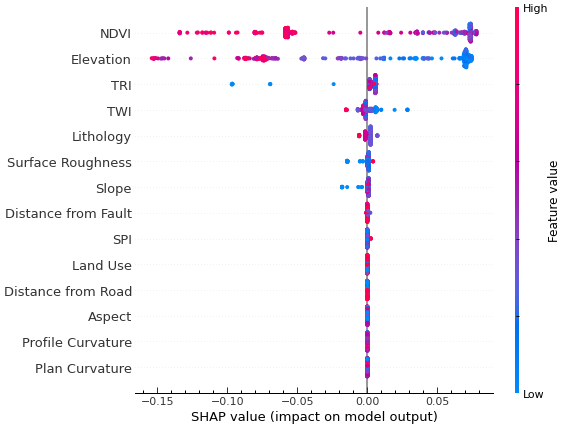

In [98]:
fig_root = os.getcwd()
fig_type = 'summary'
shap.summary_plot(shap_values, df_test[predictors],show=False)
figpath = os.path.join(fig_root,'figure', fig_type, 'lgb_summary.png')
plt.savefig(figpath, dpi=600)

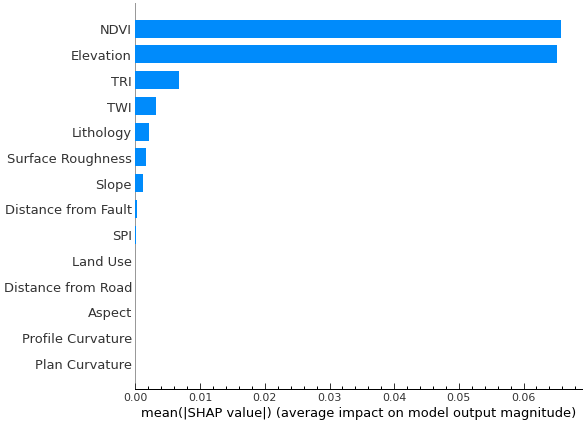

In [99]:
fig_root = os.getcwd()
fig_type = 'summary'
shap.summary_plot(shap_values, df_test[predictors],plot_type="bar",show=False)
figpath = os.path.join(fig_root,'figure', fig_type, 'lgb_bar.png')
plt.savefig(figpath, dpi=600)

In [100]:
shap_interaction_values = shap.TreeExplainer(lgb_model).shap_interaction_values(df_test[labels])

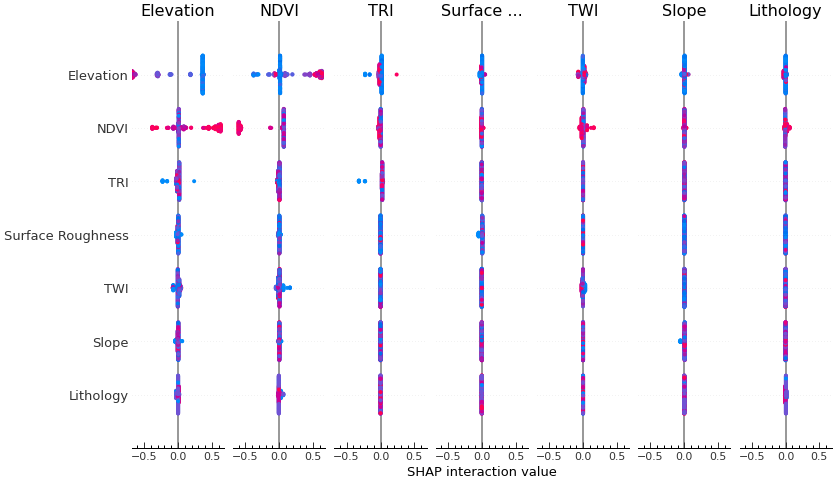

In [101]:
fig_root = os.getcwd()
fig_type = 'summary'
shap.summary_plot(shap_interaction_values, df_test[predictors],show=False)
figpath = os.path.join(fig_root,'figure', fig_type, 'lgb_all.png')
plt.savefig(figpath, dpi=600)

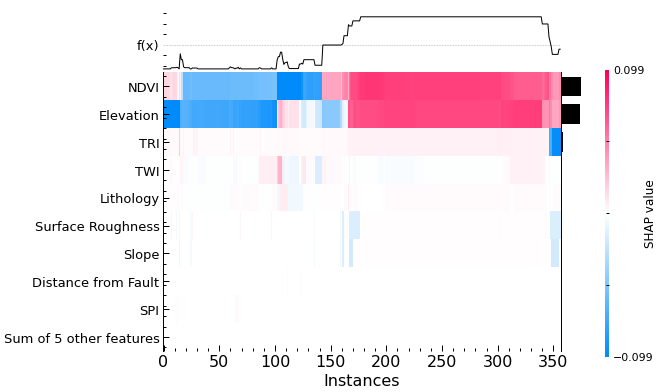

In [103]:
shap_values_obj = explainer(df_test[labels])
fig_root = os.getcwd()
fig_type = 'summary'
shap.plots.heatmap(shap_values_obj,show=False)
figpath = os.path.join(fig_root,'figure', fig_type, 'lgb_heat.png')
plt.savefig(figpath, dpi=600)

### dependence_plot

In [102]:
model_name = 'lgb'
fig_root = os.path.join(os.getcwd(),'figure', model_name)
fig_type = 'dependence'
for item in tqdm(predictors):
    shap.dependence_plot(item,
                         shap_values,
                         df_test[predictors],
                         interaction_index=None,
                         show=False)
    figpath = os.path.join(fig_root, fig_type, item + '.PNG')
    plt.savefig(figpath, dpi=600)
    plt.close()

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  3.28it/s]


### Interaction

In [104]:
fig_root = os.path.join(os.getcwd(),'figure', model_name)
fig_type = 'Interaction'
for i in tqdm(range(len(predictors))):
    for j in range(len(predictors)):
        # print(X_columns[i] + "_" + X_columns[j])
        col_i = predictors[i]
        col_j = predictors[j]
        shap.dependence_plot(col_i,
                             shap_values,
                             df_test[predictors],
                             interaction_index=col_j,
                             show=False)
        filename = col_i + '_' + col_j
        figpath = os.path.join(fig_root, fig_type, filename + '.PNG')
        plt.savefig(figpath, dpi=600)
        plt.close()

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:16<00:00,  5.48s/it]


In [105]:
shap_interaction_values.shape

(357, 14, 14)

### Interaction_value

In [106]:
fig_root = os.path.join(os.getcwd(), 'figure', model_name)
fig_type = 'Interaction_value'
for i in tqdm(range(len(predictors))):
    for j in range(len(predictors)):
        # print(X_columns[i] + "_" + X_columns[j])
        col_i = predictors[i]
        col_j = predictors[j]
        #         print(col_i, col_j)
        shap.dependence_plot((col_i, col_j),
                             shap_interaction_values,
                             df_test[predictors],
                             interaction_index=col_j,
                             show=False)
        filename = col_i + '_' + col_j
        figpath = os.path.join(fig_root, fig_type, filename + '.PNG')
        plt.savefig(figpath, dpi=600)
        plt.close()

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:17<00:00,  5.52s/it]


# 随机森林

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import  RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score, average_precision_score, cohen_kappa_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from itertools import combinations
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

## 调参

In [108]:
rf_best_params={}

### n_estmators

In [109]:
params_test1 = {'n_estimators': [100, 200, 400, 800, 1000, 1200, 1500]}

gsearch1 = GridSearchCV(estimator=RandomForestClassifier(**rf_best_params),
                        param_grid=params_test1,
                        scoring='f1',
                        cv=5,
                        n_jobs=-1)
gsearch1.fit(df_train[labels], df_train['landslides'])
gsearch1.best_score_, gsearch1.best_params_

(0.9041318120806225, {'n_estimators': 800})

In [110]:
rf_best_params.update(gsearch1.best_params_)

### min_samples_split

In [111]:
params_test2 = {'min_samples_split':range(1,41,5)}

gsearch2 = GridSearchCV(estimator=RandomForestClassifier(**rf_best_params),
                        param_grid=params_test2,
                        scoring='f1',
                        cv=5,
                        n_jobs=-1)
gsearch2.fit(df_train[labels], df_train['landslides'])
gsearch2.best_score_, gsearch2.best_params_


5 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\312\.conda\envs\lbtf2\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\312\.conda\envs\lbtf2\lib\site-packages\sklearn\ensemble\_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "C:\Users\312\.conda\envs\lbtf2\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\312\.conda\envs\lbtf2\lib\site-packages\joblib\parallel.py", line 861, in dispatch_one_batch
    self._dispatch(ta

(0.9002971730448616, {'min_samples_split': 6})

In [112]:
params_test3 = {'min_samples_split':range(2,11,1)}

gsearch3 = GridSearchCV(estimator=RandomForestClassifier(**rf_best_params),
                        param_grid=params_test3,
                        scoring='f1',
                        cv=5,
                        n_jobs=-1)
gsearch3.fit(df_train[labels], df_train['landslides'])
gsearch3.best_score_, gsearch3.best_params_

(0.9064841567418803, {'min_samples_split': 8})

In [113]:
rf_best_params.update(gsearch3.best_params_)

### max_depth

In [114]:
params_test4 = {'max_depth':range(10,100,5)}

gsearch4 = GridSearchCV(estimator=RandomForestClassifier(**rf_best_params),
                        param_grid=params_test4,
                        scoring='f1',
                        cv=5,
                        n_jobs=-1)
gsearch4.fit(df_train[labels], df_train['landslides'])
gsearch4.best_score_, gsearch4.best_params_

(0.9058403713826999, {'max_depth': 15})

In [116]:
params_test4 = {'max_depth':range(3,25,1)}

gsearch4 = GridSearchCV(estimator=RandomForestClassifier(**rf_best_params),
                        param_grid=params_test4,
                        scoring='f1',
                        cv=5,
                        n_jobs=-1)
gsearch4.fit(df_train[labels], df_train['landslides'])
print(gsearch4.best_score_, gsearch4.best_params_)
rf_best_params.update(gsearch4.best_params_)

0.9073528413761229 {'max_depth': 8}


## 最终参数

In [40]:
RandomForestClassifier?

In [117]:
rf = RandomForestClassifier(**rf_best_params)
rf.fit(df_train[labels], df_train['landslides'])

RandomForestClassifier(max_depth=8, min_samples_split=8, n_estimators=800)

## 测试集

### 保存模型

In [258]:
joblib.dump(rf, r'rf_model.pkl')

['rf_model.pkl']

### 加载模型

In [26]:
rf = joblib.load(r'rf_model.pkl')

### 测试

In [53]:
rf_pred_train = rf.predict(df_train[labels])
rf_prob_train = rf.predict_proba(df_train[labels])[:, 1]
f1_train = f1_score(df_train['landslides'], rf_pred_train)
print('train_f1:{}'.format(f1_train))

rf_pred_test = rf.predict(df_test[labels])  # 预测
rf_prob_test = rf.predict_proba(df_test[labels])[:, 1]

auc_value = roc_auc_score(df_test['landslides'], rf_prob_test)

fpr, tpr, thresholds_roc = roc_curve(df_test['landslides'], rf_prob_test)
print('auc:{}'.format(auc_value))

rf_recall_value = recall_score(df_test['landslides'], rf_pred_test)

print('训练集预测均值：{}'.format(1-rf_prob_train.mean()))
print('训练集标签均值：{}'.format(1-rf_pred_train.mean()))
print('测试集预测均值：{}'.format(1-rf_prob_test.mean()))
print('测试集标签均值：{}'.format(1-rf_pred_test.mean()))

print('racall:{}'.format(rf_recall_value))
rf_precision_value = precision_score(df_test['landslides'], rf_pred_test)
print('precision:{}'.format(rf_precision_value))
rf_f1 = f1_score(df_test['landslides'], rf_pred_test)
print('f1:{}'.format(rf_f1))
precision_list, recall_list, thresholds = precision_recall_curve(
    df_test['landslides'], rf_prob_test)

auc_pr = average_precision_score(df_test['landslides'], rf_prob_test)
print('prc:{}'.format(auc_pr))
print(rf_pred_test.mean())
print(rf_prob_test.mean())

train_f1:0.9537624660018134
auc:0.9281858129315756
训练集预测均值：0.49710444429494227
训练集标签均值：0.4715219421101774
测试集预测均值：0.5042346802787552
测试集标签均值：0.48459383753501406
racall:0.8926553672316384
precision:0.8586956521739131
f1:0.8753462603878116
prc:0.9061729214755804
0.5154061624649859
0.4957653197212448


In [54]:
rf_precisions, rf_recalls, rf_fpr, rf_tpr, rf_prc, rf_auc = precision_list, recall_list, fpr, tpr, auc_pr, auc_value

## 特征解释

In [119]:
predictors = labels

In [120]:
import shap

In [121]:
explainer = shap.TreeExplainer(rf,
                               model_output='probability',
                               feature_perturbation='interventional',
                               data=df_test[predictors])  # 初始化解释器
shap.initjs()  #初始化JS
shap_values = explainer.shap_values(df_test[predictors])  #计算每个样本的每个特征的SHAP值

 96%|=================== | 689/714 [00:21<00:00]       

In [122]:
shap_values = shap_values[1]

In [123]:
y_base = explainer.expected_value
print(y_base)

print(rf_prob_test.mean())

[0.5885171 0.4114829]
0.4957653197212448


In [124]:
model_name = 'rf'

### 个体解释

In [125]:
fig_root = os.getcwd()
fig_type = 'landslide_sample'
for i in tqdm(np.where(df_test['landslides']==1)[0]):
    shap.force_plot(0.4,
                    shap_values[i, :],
                    df_test[predictors].iloc[i],
                    matplotlib=True,
                    show=False,
                    # link='logit',
                   )
    figure_name = str(i)+'_'+'{:.2f}'.format(rf_prob_test[i])
    figpath = os.path.join(fig_root,'figure', model_name, fig_type, figure_name + '.PNG')
    plt.savefig(figpath, dpi=600)
    plt.close()

100%|████████████████████████████████████████████████████████████████████████████████| 177/177 [04:51<00:00,  1.65s/it]


In [126]:
fig_root = os.getcwd()
fig_type = 'no_landslide'
for i in tqdm(np.where(df_test['landslides']==0)[0]):
    shap.force_plot(0.4,
                    shap_values[i, :],
                    df_test[predictors].iloc[i],
                    matplotlib=True,
                    show=False,
                    # link='logit',
                   )
    figure_name = str(i)+'_'+'{:.2f}'.format(rf_prob_test[i])
    figpath = os.path.join(fig_root,'figure', model_name, fig_type, figure_name + '.PNG')
    plt.savefig(figpath, dpi=600)
    plt.close() 

100%|████████████████████████████████████████████████████████████████████████████████| 180/180 [05:04<00:00,  1.69s/it]


### summary

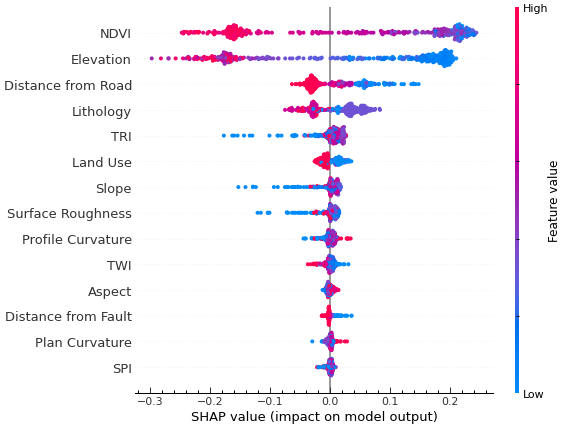

In [127]:
fig_root = os.getcwd()
fig_type = 'summary'
shap.summary_plot(shap_values, df_test[predictors],show=False)
figpath = os.path.join(fig_root,'figure', fig_type, 'rf_summary.png')
plt.savefig(figpath, dpi=600)

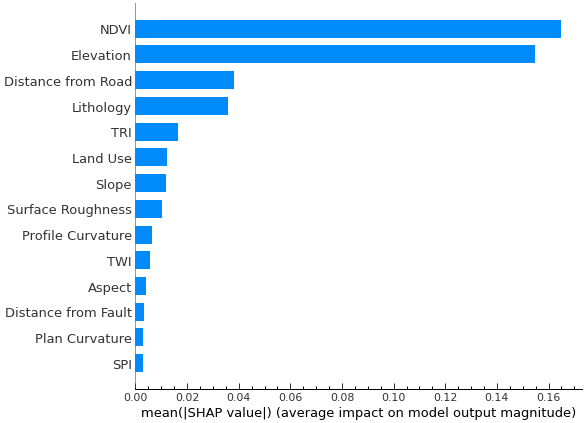

In [128]:
fig_root = os.getcwd()
fig_type = 'summary'
shap.summary_plot(shap_values, df_test[predictors],plot_type="bar",show=False)
figpath = os.path.join(fig_root,'figure', fig_type, 'rf_bar.png')
plt.savefig(figpath, dpi=600)

In [129]:
shap_interaction_values = shap.TreeExplainer(rf).shap_interaction_values(df_test[labels])

In [130]:
shap_interaction_values = shap_interaction_values[1]

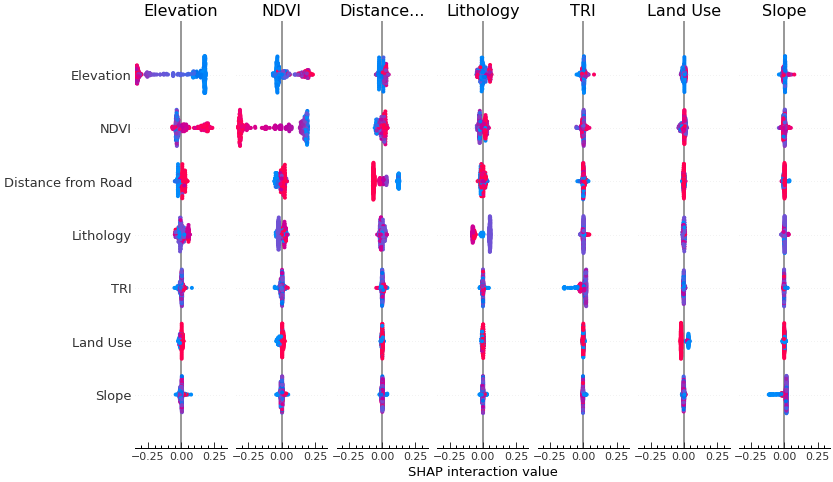

In [131]:
fig_root = os.getcwd()
fig_type = 'summary'
shap.summary_plot(shap_interaction_values, df_test[predictors], show=False)
figpath = os.path.join(fig_root,'figure', fig_type, 'rf_all.png')
plt.savefig(figpath, dpi=600)

 97%|=================== | 693/714 [00:21<00:00]       

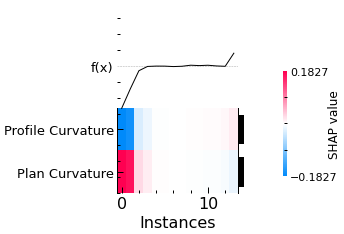

In [135]:
shap_values_obj = explainer(df_test[labels])[1]
fig_root = os.getcwd()
fig_type = 'summary'
shap.plots.heatmap(shap_values_obj,show=False)
figpath = os.path.join(fig_root,'figure', fig_type, 'rf_heat.png')
plt.savefig(figpath, dpi=600)

### dependence_plot

In [136]:
fig_root = os.path.join(os.getcwd(),'figure', model_name)
fig_type = 'dependence'
for item in tqdm(predictors):
    shap.dependence_plot(item,
                         shap_values,
                         df_test[predictors],
                         interaction_index=None,
                         show=False)
    figpath = os.path.join(fig_root, fig_type, item + '.PNG')
    plt.savefig(figpath, dpi=600)
    plt.close()

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  3.31it/s]


### Interaction

In [137]:
fig_root = os.path.join(os.getcwd(),'figure', model_name)
fig_type = 'Interaction'
for i in tqdm(range(len(predictors))):
    for j in range(len(predictors)):
        # print(X_columns[i] + "_" + X_columns[j])
        col_i = predictors[i]
        col_j = predictors[j]
        shap.dependence_plot(col_i,
                             shap_values,
                             df_test[predictors],
                             interaction_index=col_j,
                             show=False)
        filename = col_i + '_' + col_j
        figpath = os.path.join(fig_root, fig_type, filename + '.PNG')
        plt.savefig(figpath, dpi=600)
        plt.close()

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:18<00:00,  5.57s/it]


In [138]:
shap_interaction_values.shape

(357, 14, 14)

### Interaction_value

In [139]:
fig_root = os.path.join(os.getcwd(), 'figure', model_name)
fig_type = 'Interaction_value'
for i in tqdm(range(len(predictors))):
    for j in range(len(predictors)):
        # print(X_columns[i] + "_" + X_columns[j])
        col_i = predictors[i]
        col_j = predictors[j]
        #         print(col_i, col_j)
        shap.dependence_plot((col_i, col_j),
                             shap_interaction_values,
                             df_test[predictors],
                             interaction_index=col_j,
                             show=False)
        filename = col_i + '_' + col_j
        figpath = os.path.join(fig_root, fig_type, filename + '.PNG')
        plt.savefig(figpath, dpi=600)
        plt.close()

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:19<00:00,  5.65s/it]


# 总图

In [32]:
fig_root = os.path.join(os.getcwd(), 'figure')
fig_type = 'summary'

## ROC

<Figure size 576x432 with 0 Axes>

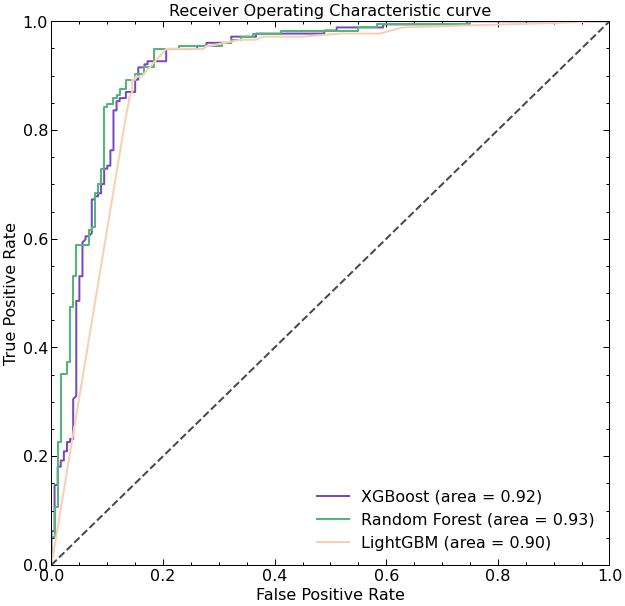

In [55]:
plt.figure()
lw = 2
plt.figure(figsize=(10, 10))
plt.plot(xgb_fpr,
         xgb_tpr,
         color='#7549c1',
         lw=lw,
         label='XGBoost (area = %0.2f)' % xgb_auc)  # 假正率为横坐标，真正率为纵坐标做曲线

plt.plot(rf_fpr,
         rf_tpr,
         color='#4EB877',
         lw=lw,
         label='Random Forest (area = %0.2f)' % rf_auc)  # 假正率为横坐标，真正率为纵坐标做曲线

plt.plot(lgb_fpr,
         lgb_tpr,
         color='#fdcdb3',
         lw=lw,
         label='LightGBM (area = %0.2f)' % lgb_auc)  # 假正率为横坐标，真正率为纵坐标做曲线

plt.plot([0, 1], [0, 1], color='#484848', lw=lw, linestyle='--')
plt.xlim([0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic curve')
plt.legend(loc="lower right")
figpath = os.path.join(fig_root, fig_type, 'ROC.PNG')
plt.savefig(figpath, dpi=600)

## PRC

<Figure size 576x432 with 0 Axes>

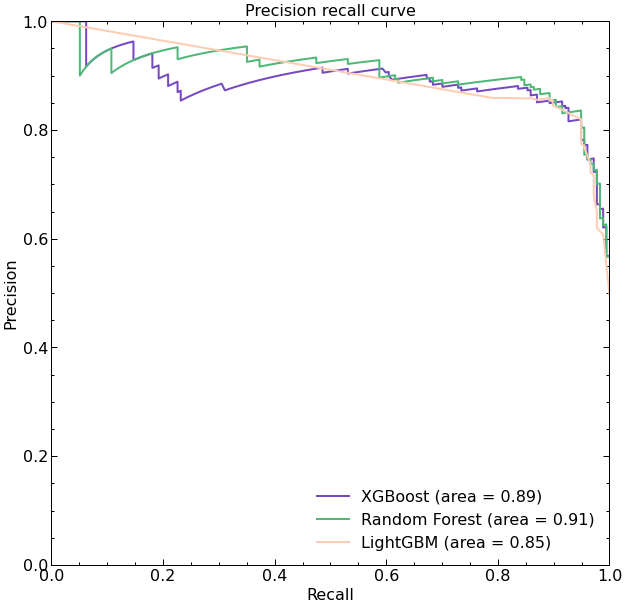

In [56]:
plt.figure()
lw = 2
plt.figure(figsize=(10, 10))
plt.plot(xgb_recalls,
         xgb_precisions,
         color='#7549c1',
         lw=lw,
         label='XGBoost (area = %0.2f)' %
         xgb_prc)  # 假正率为横坐标，真正率为纵坐标做曲线

plt.plot(rf_recalls,
         rf_precisions,
         color='#4EB877',
         lw=lw,
         label='Random Forest (area = %0.2f)' %
         rf_prc)  # 假正率为横坐标，真正率为纵坐标做曲线

plt.plot(lgb_recalls,
         lgb_precisions,
         color='#fdcdb3',
         lw=lw,
         label='LightGBM (area = %0.2f)' %
         lgb_prc)  # 假正率为横坐标，真正率为纵坐标做曲线

# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision recall curve')
plt.legend(loc="lower right")
figpath = os.path.join(fig_root, fig_type, 'PRC.PNG')
plt.savefig(figpath, dpi=600)

## bar

# LSM

## 读取factor

In [60]:
root = os.path.join(os.getcwd(), 'factors')


def file2list(filename):

    #     获取文件信息
    filepath = os.path.join(root, filename)
    f = open(filepath)
    fileinfo = {}
    for i in range(6):
        a = f.readline().split()
        fileinfo.update({a[0]: a[1]})
    f.close()
    ASCfile = pd.read_csv(
        filepath,
        skiprows=6,
        encoding="gbk",
        engine='python',
        sep=' ',
        delimiter=None,
        index_col=False,
        header=None,
        skipinitialspace=True,
        na_values=fileinfo['NODATA_value'],
    )
    #     if 'use' in filename:
    #         ASCfile.pop(ASCfile.columns[-1])
    print(ASCfile.shape)
    print(fileinfo)
    return ASCfile.to_numpy().flatten()

In [58]:
file_list = [
    item for item in os.listdir(root)
    if ('txt' in item) & ('spi_1' not in item)
]

In [61]:
names = []
for file in file_list:
    name = file.split('.')[0]
    names.append(name)
    print(name,end=' ')
    exec(name + '=file2list(file)')

aspect (4011, 4836)
{'ncols': '4835', 'nrows': '4011', 'xllcorner': '110.31868743897', 'yllcorner': '30.467168807983', 'cellsize': '0.000277777778', 'NODATA_value': '-9999'}
elevation (4011, 4836)
{'ncols': '4835', 'nrows': '4011', 'xllcorner': '110.31868743897', 'yllcorner': '30.467168807983', 'cellsize': '0.000277777778', 'NODATA_value': '-9999'}
fault (4011, 4836)
{'ncols': '4835', 'nrows': '4011', 'xllcorner': '110.31868743897', 'yllcorner': '30.467168807983', 'cellsize': '0.000277777778', 'NODATA_value': '-9999'}
landuse (4011, 4836)
{'ncols': '4835', 'nrows': '4011', 'xllcorner': '110.31868743897', 'yllcorner': '30.467168807983', 'cellsize': '0.000277777778', 'NODATA_value': '-9999'}
lithology (4011, 4836)
{'ncols': '4835', 'nrows': '4011', 'xllcorner': '110.31868743897', 'yllcorner': '30.467168807984', 'cellsize': '0.000277777778', 'NODATA_value': '-9999'}
ndvi (4011, 4836)
{'ncols': '4835', 'nrows': '4011', 'xllcorner': '110.31868743897', 'yllcorner': '30.467168807983', 'cellsi

In [62]:
str_name = ','.join(names)

In [65]:
str_name

'aspect,elevation,fault,landuse,lithology,ndvi,plancur,procur,road,slope,spi_sca,sr,tri,twi'

In [70]:
labels

['Plan Curvature',
 'Profile Curvature',
 'SPI',
 'NDVI',
 'TWI',
 'TRI',
 'Surface Roughness',
 'Elevation',
 'Aspect',
 'Slope',
 'Lithology',
 'Distance from Road',
 'Distance from Fault',
 'Land Use']

## 处理数据

In [72]:
data_dict = {
    'Plan Curvature': plancur,
    'Profile Curvature':procur,
    'SPI': spi_sca,
    'NDVI':ndvi,
    'TWI':twi,
    'TRI':tri,
    'Surface Roughness':sr,
    'Elevation':elevation,
    'Aspect':aspect,
    'Slope':slope,
    'Lithology': lithology,
    'Distance from Road':road,
    'Distance from Fault':fault,
    'Land Use':landuse,
}

In [73]:
data_ori = pd.DataFrame(data_dict)

In [76]:
ori_index = data_ori.index

In [77]:
data_nona = data_ori.dropna()


In [80]:
road_dict = {0: 0, 300: 1, 500: 2, 800: 3, 1200: 4, 2000: 5, 200000: 6}
fault_dict = {0: 0, 300: 1, 500: 2, 800: 3, 1200: 4, 2000: 5, 3000:6, 50000: 7}
landuse_dict = {0: 0, 50: 1, 60: 2, 10: 3, 80: 4, 30: 5, 20: 6}
data_nona['Distance from Road'] = [road_dict[item] for item in data_nona['Distance from Road']]
data_nona['Distance from Fault'] = [fault_dict[item] for item in data_nona['Distance from Fault']]
data_nona['Land Use'] = [landuse_dict[item] for item in data_nona['Land Use']]

C:\Users\312\.conda\envs\lbtf2\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\312\.conda\envs\lbtf2\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\312\.conda\envs\lbtf2\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

In [82]:
data_nona[float_label] = np.round(data_nona[float_label], 3)

C:\Users\312\.conda\envs\lbtf2\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [84]:
data_nona.to_csv('data_nona_value.csv')

In [85]:
data_ori.to_csv('data_ori.csv')

## 读取文件

In [86]:
df_nona = pd.read_csv(
    'data_nona_value.csv',
    header=0,
#     chunksize=2**15,
    index_col=[0],
)

### rf

In [87]:
y_prob_rf = rf.predict_proba(df_nona[labels])

In [88]:
y_prob_rf_df = pd.DataFrame(y_prob_rf, index=df_nona.index, columns=[0,1])

In [89]:
y_prob_rf_df.describe()

,0,1
count,1.023846e+07,1.023846e+07
mean,8.220812e-01,1.779188e-01
std,2.293844e-01,2.293844e-01
min,1.894991e-02,4.809153e-04
25%,7.713180e-01,2.423001e-02
50%,9.198347e-01,8.016527e-02
75%,9.757700e-01,2.286820e-01
max,9.995191e-01,9.810501e-01


In [98]:
output_rf = pd.DataFrame(np.ones_like(data_ori['Aspect']) * -9999)
output_rf.iloc[df_nona.index] = pd.DataFrame(
    y_prob_rf_df[1], index=y_prob_rf_df.index)

In [101]:
np.savetxt(os.path.join(os.getcwd(), 'txt', r'sen_rf.txt'), output_rf.to_numpy().reshape(
    (4011, 4836)), fmt='%.4f')

### xgb

In [102]:
y_prob_xgb = xgb4.predict_proba(df_nona[labels])

In [105]:
y_prob_xgb_df = pd.DataFrame(y_prob_xgb, index=df_nona.index, columns=[0,1])

In [106]:
y_prob_xgb_df.describe()

,0,1
count,1.023846e+07,1.023846e+07
mean,8.321449e-01,1.958788e-01
std,2.367001e-01,2.356318e-01
min,7.513791e-02,2.262591e-02
25%,7.191747e-01,3.272257e-02
50%,9.109101e-01,8.908987e-02
75%,9.672774e-01,2.808253e-01
max,9.773741e-01,9.248621e-01


In [107]:
output_xgb = pd.DataFrame(np.ones_like(data_ori['Aspect']) * -9999)
output_xgb.iloc[df_nona.index] = pd.DataFrame(
    y_prob_xgb_df[1], index=y_prob_xgb_df.index)

In [108]:
np.savetxt(os.path.join(os.getcwd(), 'txt', r'sen_xgb.txt'),
           output_xgb.to_numpy().reshape((4011, 4836)),
           fmt='%.4f')

### lgb

In [109]:
y_prob_lgb = lgb_model.predict_proba(df_nona[labels])

In [110]:
y_prob_lgb_df = pd.DataFrame(y_prob_lgb, index=df_nona.index, columns=[0,1])

In [111]:
y_prob_lgb_df.describe()

,0,1
count,1.023846e+07,1.023846e+07
mean,6.043873e-01,3.956127e-01
std,9.083074e-02,9.083074e-02
min,3.741448e-01,3.395717e-01
25%,5.806407e-01,3.395717e-01
50%,6.538051e-01,3.461949e-01
75%,6.604283e-01,4.193593e-01
max,6.604283e-01,6.258552e-01


In [113]:
output_lgb = pd.DataFrame(np.ones_like(data_ori['Aspect']) * -9999)
output_lgb.iloc[df_nona.index] = pd.DataFrame(
    y_prob_lgb_df[1], index=y_prob_lgb_df.index)

In [114]:
np.savetxt(os.path.join(os.getcwd(), 'txt', r'sen_lgb.txt'),
           output_lgb.to_numpy().reshape((4011, 4836)),
           fmt='%.4f')